In [ ]:
!git clone https://github.com/CASIA-IVA-Lab/FastSAM.git

!wget https://huggingface.co/spaces/An-619/FastSAM/resolve/main/weights/FastSAM.pt

!pip install -r FastSAM/requirements.txt
!pip install git+https://github.com/openai/CLIP.git

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import cv2
import numpy as np
import pandas as pd
import random
from PIL import Image
import matplotlib.pyplot as plt
import statistics


img_height = 224
img_width = 224

def most_occuring(roi):
    max_value = roi[0]
    max_count = 1
    current_value = roi[0]
    current_count = 1

    for i in range(1, len(roi)):
        if roi[i] == current_value:
            current_count += 1
        else:
            if current_count > max_count:
                max_value = current_value
                max_count = current_count
            current_value = roi[i]
            current_count = 1

    if current_count > max_count:
        max_value = current_value

    return max_value if max_count > 1 else img_height


def preprocess_image_rgb(img):
    """
    Preprocess the input RGB image to enhance edges by applying edge detection on each channel.

    Parameters:
    img (np.ndarray): The input RGB image as a NumPy array.

    Returns:
    np.ndarray: Combined edge-detected image from all channels.
    """
    channels = cv2.split(img)
    edges = []

    for channel in channels:
        blurred_channel = cv2.GaussianBlur(channel, (5, 5), 0)
        adaptive_thresh = cv2.adaptiveThreshold(
            blurred_channel, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)

        kernel = np.ones((3, 3), np.uint8)
        morph_channel = cv2.morphologyEx(adaptive_thresh, cv2.MORPH_CLOSE, kernel, iterations=2)
        morph_channel = cv2.morphologyEx(morph_channel, cv2.MORPH_OPEN, kernel, iterations=2)

        channel_edges = cv2.Canny(morph_channel, 30, 100)
        edges.append(channel_edges)

    combined_edges = cv2.bitwise_or(edges[0], edges[1])
    combined_edges = cv2.bitwise_or(combined_edges, edges[2])

    return combined_edges

def find_initial_edges_rgb(img, interval, step, gap):
    if not isinstance(img, np.ndarray) or img.dtype != np.uint8:
        raise ValueError("Image must be a NumPy array of type uint8")
    if interval <= 0 or not isinstance(interval, int):
        raise ValueError("Interval must be a positive integer")

    edges = preprocess_image_rgb(img)

    image_height, image_width = img.shape[:2]
    col_indices = np.arange(0, image_width, interval)

    up_start, low_start = int(image_height / 4), int(image_height * 3 / 4)
    upper_edge_rvals = np.full(len(col_indices), up_start, dtype=np.uint16)
    lower_edge_rvals = np.full(len(col_indices), low_start, dtype=np.uint16)
    upper_edge_found = np.zeros(len(col_indices), dtype=bool)
    lower_edge_found = np.zeros(len(col_indices), dtype=bool)

    for i, c in enumerate(col_indices):
        col = edges[:, c]
        col = col[up_start:low_start+1]

        upper_r, lower_r = up_start, low_start

        for r in range(up_start, low_start):
            if col[r - up_start] == 255:
                upper_edge_rvals[i] = r
                upper_edge_found[i] = True
                break

        for r in range(low_start, up_start, -1):
            if col[r - up_start] == 255:
                lower_edge_rvals[i] = r
                lower_edge_found[i] = True
                break

    return upper_edge_rvals, lower_edge_rvals, upper_edge_found, lower_edge_found

def simulated_annealing(col_indices, upper_edge_rvals, lower_edge_rvals, up_start, low_start, upper_edge_found, lower_edge_found, iterations, initial_temp, cooling_rate, step):
    temp = initial_temp
    for _ in range(iterations):
        for i in range(1, len(col_indices) - 1):
            if not upper_edge_found[i]:
                current_upper_r = upper_edge_rvals[i]
                new_upper_r = current_upper_r + np.random.randint(-step, step)
                new_upper_r = np.clip(new_upper_r, up_start, low_start)
                if new_upper_r < lower_edge_rvals[i] - 10:
                    current_cost = np.abs(current_upper_r - np.mean([upper_edge_rvals[i-1], upper_edge_rvals[i+1]]))
                    new_cost = np.abs(new_upper_r - np.mean([upper_edge_rvals[i-1], upper_edge_rvals[i+1]]))
                    if new_cost < current_cost or np.exp((current_cost - new_cost) / temp) > np.random.rand():
                        upper_edge_rvals[i] = new_upper_r

            if not lower_edge_found[i]:
                current_lower_r = lower_edge_rvals[i]
                new_lower_r = current_lower_r + np.random.randint(-step, step)
                new_lower_r = np.clip(new_lower_r, up_start, low_start)
                if new_lower_r > upper_edge_rvals[i] + 10:
                    current_cost = np.abs(current_lower_r - np.mean([lower_edge_rvals[i-1], lower_edge_rvals[i+1]]))
                    new_cost = np.abs(new_lower_r - np.mean([lower_edge_rvals[i-1], lower_edge_rvals[i+1]]))
                    if new_cost < current_cost or np.exp((current_cost - new_cost) / temp) > np.random.rand():
                        lower_edge_rvals[i] = new_lower_r

        temp *= cooling_rate

    return upper_edge_rvals, lower_edge_rvals

def local_smoothing(arr, window_size=5):
    return np.convolve(arr, np.ones(window_size)/window_size, mode='same')

def process_single_image(np_img, channels, intvl, step, gap, iterations=1000, initial_temp=1.0, cooling_rate=0.99):
    interval = intvl

    if channels == 1:
        raise NotImplementedError("Simulated annealing is currently implemented for RGB images only.")
    else:
        col_indices = np.arange(0, np_img.shape[1], interval)
        upper_edge_row_vals, lower_edge_row_vals, upper_edge_found, lower_edge_found = find_initial_edges_rgb(np_img, interval, step, gap)
        up_start, low_start = int(np_img.shape[0] / 4), int(np_img.shape[0] * 3 / 4)

        initial_upper_edge_row_vals = upper_edge_row_vals.copy()
        initial_lower_edge_row_vals = lower_edge_row_vals.copy()

        upper_edge_row_vals, lower_edge_row_vals = simulated_annealing(
            col_indices, upper_edge_row_vals, lower_edge_row_vals, up_start, low_start, upper_edge_found, lower_edge_found, iterations, initial_temp, cooling_rate, step
        )

        upper_edge_row_vals[upper_edge_found] = initial_upper_edge_row_vals[upper_edge_found]
        lower_edge_row_vals[lower_edge_found] = initial_lower_edge_row_vals[lower_edge_found]

    return upper_edge_row_vals, lower_edge_row_vals


In [4]:
## process joint spaces.csv

csv_path = '/content/drive/MyDrive/Colab/Thesis_UG_Buet/joint_spaces.csv'

df = pd.read_csv(csv_path)
print(df)

   grade  l_cmov  l_mode     l_mean  l_med     l_std  r_cmov  r_mode  \
0      0      18      18  18.911638   18.0  2.583676      18      18   
1      1      18      18  15.948929   15.0  2.879633      18      18   
2      2      15      15  14.305970   15.0  4.079851      15      15   
3      3      12      12  11.804178   12.0  4.018987      12      12   
4      4      12      12  11.388350   12.0  4.717727      12      12   

      r_mean  r_med     r_std  
0  18.885776   18.0  2.422482  
1  16.339374   18.0  2.845294  
2  14.453731   15.0  3.765925  
3  12.689295   12.0  2.412990  
4  11.737864   12.0  4.823005  


In [5]:
joint_spaces_px = [[19, 19], [16, 16], [14, 14], [11, 12], [11, 11]]

# Calculate joint spaces percentage
joint_spaces_percentage = np.array(joint_spaces_px) * 100 / img_height

# Round to 2 decimal places
joint_spaces_percentage = np.round(joint_spaces_percentage)

# Convert to list and print
joint_spaces_percentage = joint_spaces_percentage.tolist()
print(joint_spaces_percentage)


# Class names for knee osteoarthritis classification
class_names = ["No", "Yes", "Invalid"] # 0, 1, -1

def find_class(joint_space_percentage):
  if(joint_space_percentage[0] < 7 or joint_space_percentage[0] < 7):
    return 1
  elif(joint_space_percentage[0] < 10 or joint_space_percentage[1] < 10):
    return 0
  else:
    return -1

[[8.0, 8.0], [7.0, 7.0], [6.0, 6.0], [5.0, 5.0], [5.0, 5.0]]


**See results for a single image**

In [13]:
def accuracy_single_image(test_image_path):
  original_img = Image.open(test_image_path)

  img_name = os.path.basename(test_image_path)  # This includes the .png extension
  img_label = os.path.basename(os.path.dirname(test_image_path))  # This gets the parent directory name
  img_label_int = int(img_label)

  # Run inference on the input image using FastSAM
  !python FastSAM/Inference.py --model_path FastSAM.pt --img_path $test_image_path --imgsz $img_height

  print('segmentation done')

  seg_image_path = f'/content/output/{img_name}'

  if os.path.exists(seg_image_path):
      segmented_img = Image.open(seg_image_path)
  else:
      return -1

  fig, axs = plt.subplots(2, 2, figsize=(7, 7))
  # Plot the original image
  axs[0, 0].imshow(original_img, cmap='gray')
  axs[0, 0].set_title('Original Image')

  # Plot the segmented image
  axs[0, 1].imshow(segmented_img, cmap='gray')
  axs[0, 1].set_title('Segmented Image')


  np_img = np.array(segmented_img)
  upper_edge_row_vals, lower_edge_row_vals = process_single_image(np_img, channels=3, intvl=4, step=4, gap=20, iterations=1000, initial_temp=1.0, cooling_rate=0.99)

  # Plot the fastsam image + edge
  axs[1, 0].imshow(segmented_img, cmap='gray')
  axs[1, 0].scatter(range(0, 224, 4), upper_edge_row_vals, color='r', s=1)
  axs[1, 0].scatter(range(0, 224, 4), lower_edge_row_vals, color='b', s=1)
  axs[1, 0].set_title('Segmented Image + Edge')

  # Plot the original image + edge
  axs[1, 1].imshow(original_img, cmap='gray')
  axs[1, 1].scatter(range(0, 224, 4), upper_edge_row_vals, color='r', s=1)
  axs[1, 1].scatter(range(0, 224, 4), lower_edge_row_vals, color='b', s=1)
  axs[1, 1].set_title('Original Image + Edge')


  # these values are determined by observation
  left_range_start = 40
  left_range_end = 70
  right_range_start = 155
  right_range_end = 185
  interval = 4


  # Plot the fastsam edges on the original image
  lrs = left_range_start // interval
  lre = left_range_end // interval
  rrs = right_range_start // interval
  rre = right_range_end // interval

  plt.figure(figsize=(5, 5))
  plt.imshow(original_img, cmap='gray')

  # Plot points within the specified ranges
  x_values = range(0, 224, interval)

  # Filter points for the left and right ranges
  left_x_values = x_values[lrs:lre]
  left_upper_vals = upper_edge_row_vals[lrs:lre]
  left_lower_vals = lower_edge_row_vals[lrs:lre]

  right_x_values = x_values[rrs:rre]
  right_upper_vals = upper_edge_row_vals[rrs:rre]
  right_lower_vals = lower_edge_row_vals[rrs:rre]

  # Scatter plot for the left range
  plt.scatter(left_x_values, left_upper_vals, color='r', s=1)
  plt.scatter(left_x_values, left_lower_vals, color='b', s=1)

  # Scatter plot for the right range
  plt.scatter(right_x_values, right_upper_vals, color='r', s=1)
  plt.scatter(right_x_values, right_lower_vals, color='b', s=1)

  plt.title('Image + Edge + ROI')
  plt.legend()

  # Draw vertical lines at specified intervals
  plt.axvline(x=left_range_start, color='g', linestyle='--')
  plt.axvline(x=left_range_end, color='g', linestyle='--')
  plt.axvline(x=right_range_start, color='g', linestyle='--')
  plt.axvline(x=right_range_end, color='g', linestyle='--')

  plt.tight_layout()
  plt.show()


  for i in range(len(upper_edge_row_vals)):
    upper_edge_row_vals[i] -= (4 - img_label_int)
  for i in range(len(lower_edge_row_vals)):
      lower_edge_row_vals[i] += (4 - img_label_int)

  joint_space = lower_edge_row_vals - upper_edge_row_vals;


  left_range_start //= interval
  left_range_end //= interval
  right_range_start //= interval
  right_range_end //= interval


  # find left_gap and right_gap
  # separate left and right range
  left_roi = joint_space[left_range_start:left_range_end]
  right_roi = joint_space[right_range_start:right_range_end]

  # Function to convert a number to the nearest multiple of 3
  def nearest_multiple_of_3(x):
      return round(x / 3) * 3

  # Convert all values to nearest multiple of 3
  left_roi = [nearest_multiple_of_3(x) for x in left_roi]
  right_roi = [nearest_multiple_of_3(x) for x in right_roi]

  # Calculate statistics for left_roi
  left_mean = np.mean(left_roi)
  left_median = np.median(left_roi)
  left_std_dev = np.std(left_roi)
  left_mov = most_occuring(left_roi)
  left_mode = statistics.mode(left_roi)

  # Calculate statistics for right_roi
  right_mean = np.mean(right_roi)
  right_median = np.median(right_roi)
  right_std_dev = np.std(right_roi)
  right_mov = most_occuring(right_roi)
  right_mode = statistics.mode(right_roi)


  joint_space = [left_mode, right_mode]
  # print(joint_space)
  # Calculate joint spaces percentage
  joint_space_percentage = np.array(joint_space) * 100 / img_height

  # Round to 2 decimal places
  joint_space_percentage = np.round(joint_space_percentage)

  # Convert to list and print
  joint_space_percentage = joint_space_percentage.tolist()
  # print(joint_space_percentage)


  return find_class(joint_space_percentage)

2024-06-24 11:00:34.459928: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-24 11:00:34.459999: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-24 11:00:34.461483: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered

0: 224x224 3 objects, 1145.9ms
Speed: 3.6ms preprocess, 1145.9ms inference, 8.1ms postprocess per image at shape (1, 3, 224, 224)
segmentation done


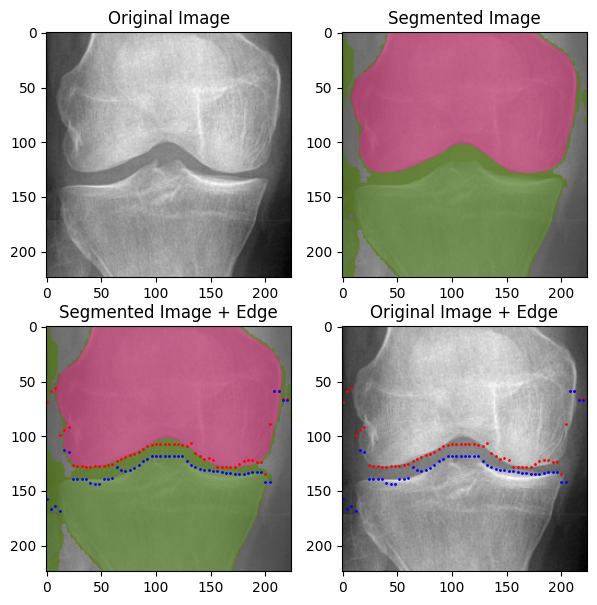

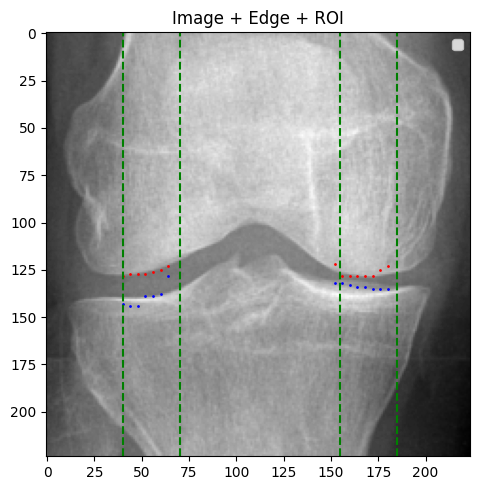

0
No


In [15]:
test_image_path = "/content/drive/MyDrive/Colab/Thesis_UG_Buet/UgThesis_test_dataset/1/9019907R.png"

cls = accuracy_single_image(test_image_path)

print(cls)
print(class_names[cls])

In [16]:
def process_image(test_image_path):
  original_img = Image.open(test_image_path)

  img_name = os.path.basename(test_image_path)  # This includes the .png extension
  img_label = os.path.basename(os.path.dirname(test_image_path))  # This gets the parent directory name
  img_label_int = int(img_label)

  # Run inference on the input image using FastSAM
  !python FastSAM/Inference.py --model_path FastSAM.pt --img_path $test_image_path --imgsz $img_height


  seg_image_path = f'/content/output/{img_name}'

  if os.path.exists(image_path):
      segmented_img = Image.open(seg_image_path)
  else:
      return -1

  np_img = np.array(segmented_img)
  upper_edge_row_vals, lower_edge_row_vals = process_single_image(np_img, channels=3, intvl=4, step=4, gap=20, iterations=1000, initial_temp=1.0, cooling_rate=0.99)

  for i in range(len(upper_edge_row_vals)):
    upper_edge_row_vals[i] -= (4 - img_label_int)
  for i in range(len(lower_edge_row_vals)):
      lower_edge_row_vals[i] += (4 - img_label_int)

  joint_space = lower_edge_row_vals - upper_edge_row_vals;


  # these values are determined by observation
  left_range_start = 40
  left_range_end = 70
  right_range_start = 155
  right_range_end = 185
  interval = 4

  left_range_start //= interval
  left_range_end //= interval
  right_range_start //= interval
  right_range_end //= interval


  # find left_gap and right_gap
  # separate left and right range
  left_roi = joint_space[left_range_start:left_range_end]
  right_roi = joint_space[right_range_start:right_range_end]

  # Function to convert a number to the nearest multiple of 3
  def nearest_multiple_of_3(x):
      return round(x / 3) * 3

  # Convert all values to nearest multiple of 3
  left_roi = [nearest_multiple_of_3(x) for x in left_roi]
  right_roi = [nearest_multiple_of_3(x) for x in right_roi]

  # Calculate statistics for left_roi
  left_mean = np.mean(left_roi)
  left_median = np.median(left_roi)
  left_std_dev = np.std(left_roi)
  left_mov = most_occuring(left_roi)
  left_mode = statistics.mode(left_roi)

  # Calculate statistics for right_roi
  right_mean = np.mean(right_roi)
  right_median = np.median(right_roi)
  right_std_dev = np.std(right_roi)
  right_mov = most_occuring(right_roi)
  right_mode = statistics.mode(right_roi)


  joint_space = [left_mode, right_mode]
  print(joint_space)
  # Calculate joint spaces percentage
  joint_space_percentage = np.array(joint_space) * 100 / img_height

  # Round to 2 decimal places
  joint_space_percentage = np.round(joint_space_percentage)

  # Convert to list and print
  joint_space_percentage = joint_space_percentage.tolist()
  print(joint_space_percentage)


  return find_class(joint_space_percentage)

In [21]:

test_dataset_path = '/content/drive/MyDrive/Colab/Thesis_UG_Buet/UgThesis_test_dataset'

# List of subfolders in the test dataset path
subfolders = ['4']

# Number of images to select from each folder
num_images = 100

# Dictionary to store results for accuracy calculation
results = {subfolder: {'correct': 0, 'total': 0} for subfolder in subfolders}

# Iterate through each subfolder
for subfolder in subfolders:
    folder_path = os.path.join(test_dataset_path, subfolder)

    if os.path.exists(folder_path):
        # List all files in the subfolder
        images = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

        # Ensure there are enough images to select from
        if len(images) >= num_images:
            # Select random images from the folder
            selected_images = random.sample(images, num_images)
        else:
            print(f"Folder {subfolder} does not have enough images. Only {len(images)} available.")
            selected_images = images

        # Run the process_image function on each selected image
        for image in selected_images:
            image_path = os.path.join(folder_path, image)
            result = process_image(image_path)

            if result == -1:
                continue
            # Check if the result is correct
            correct = (
                (subfolder in ['0', '1', '2'] and result == 0) or
                (subfolder in ['2', '3', '4'] and result == 1)
            )

            if correct:
                results[subfolder]['correct'] += 1
            results[subfolder]['total'] += 1

            print(f"Folder: {subfolder}, Image: {image}, Result: {result}, Correct: {correct}")
    else:
        print(f"Folder {subfolder} does not exist in the dataset path.")

Folder 4 does not have enough images. Only 14 available.
2024-06-24 13:33:09.654302: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-24 13:33:09.654397: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-24 13:33:09.656581: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered

0: 224x224 3 objects, 872.6ms
Speed: 4.5ms preprocess, 872.6ms inference, 5.3ms postprocess per image at shape (1, 3, 224, 224)
[12, 12]
[5.0, 5.0]
Folder: 4, Image: 9627172R.png, Result: 1, Correct: True
2024-06-24 13:33:28.005821: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to 

   Folder  Total  Correct  Accuracy (%)
0       0     92       78     84.782609
1       1     96       73     76.041667
2       2     98       98    100.000000
3       3     94       67     71.276596
4       4     25       20     80.000000
Overall Accuracy: 82.96%


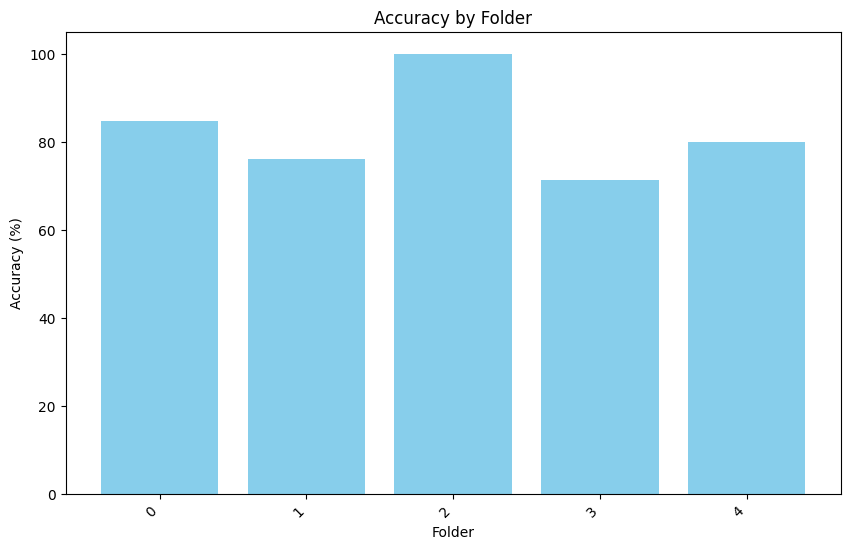

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file into a DataFrame
df = pd.read_csv('/content/drive/MyDrive/Colab/Thesis_UG_Buet/test_output.csv')

# Calculate total correct and total number of entries per folder
df_summary = df.groupby('Folder').agg(
    Total=('Result', 'count'),
    Correct=('Correct', lambda x: (x == True).sum())
).reset_index()

# Calculate accuracy per folder
df_summary['Accuracy (%)'] = (df_summary['Correct'] / df_summary['Total']) * 100

# Print the summary table
print(df_summary)

# Calculate overall accuracy
total_correct = df['Correct'].sum()
total_entries = df['Correct'].count()
overall_accuracy = (total_correct / total_entries) * 100

print(f"Overall Accuracy: {overall_accuracy:.2f}%")

# Plot the accuracy per folder
plt.figure(figsize=(10, 6))
plt.bar(df_summary['Folder'], df_summary['Accuracy (%)'], color='skyblue')
plt.xlabel('Folder')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy by Folder')
plt.xticks(rotation=45, ha='right')

# Save the plot as an image file
plt.savefig('accuracy_by_folder.png', bbox_inches='tight')

# Show the plot
plt.show()


In [ ]:
import os
import glob
import shutil
from google.colab import files

# Specify the folder path
folder_path = '/content/output'

zip_file_path = '/content/output.zip'

# Create a ZIP file of the contents of the folder
shutil.make_archive(zip_file_path.replace('.zip', ''), 'zip', folder_path)

# Download the ZIP file
files.download(zip_file_path)


# List of common image extensions
image_extensions = ['*.jpg', '*.jpeg', '*.png', '*.gif', '*.bmp', '*.tiff']

# Delete all images in the folder
for extension in image_extensions:
    image_files = glob.glob(os.path.join(folder_path, extension))
    for image_file in image_files:
        try:
            os.remove(image_file)
            print(f"Deleted: {image_file}")
        except Exception as e:
            print(f"Error deleting {image_file}: {e}")